PyTorch Deep Neural Network (non linear) training with 1 hidden layer, on a GPU. 

This small project is done after doing the PyTorch tutorial given by Aakash. After playing with the parameters, this is my first individual project using PyTorch, I used Fashion MNIST.

If you don't know it already, Fashion MNIST or FMIST is a dataset containing 60000 images of clothes (28*28 pixels) and our aim here is to create a model that will be able to accurately predict the type of fashion item for new images (examples are shoe, skirt, dress)


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

Loading the dataset FashionMNIST and transforming the dataset into tensors so that they will be used by PyTorch

In [ ]:
fmnist = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, transform=ToTensor())

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Then, we are picking a validation size and training size to randomly shuffle and split the data using random_split(). We could have chosen another way to part as long as the sum of train_size and val_size are equals to the length of FMNIST.

In [ ]:
val_size = 10000
train_size = len(fmnist) - val_size

train_data, val_data = random_split(fmnist, [train_size, val_size])
len(train_data), len(val_data)

(50000, 10000)

We are picking a batch size. This will allow the training to be done in multiple batches of a size that we chose. We can change the batch size to see how the model can improve or regress and so, understand how it works for our data.

In [ ]:
batch_size = 150

Then we will simply load the data according to the parameters that we choose juste before (the extracted training dataset, and validation dataset, the batch size) and we will also add the number of workers which is just how many sub-processes are used simoultaneously for data loading, and increases the speed to process the data.

In [ ]:
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=5, pin_memory=True)
val_loader = DataLoader(val_data, batch_size*2, num_workers=5, pin_memory=True)

To apply our model later on, we will need to get how many labels we have (how many types of clothes do we have). It turns out, we have just as many labels as in the MNIST dataset (10).

In [ ]:
# Number of labels for Fashion MNIST
torch.unique(fmnist.targets)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Let's look at a portion of our dataset.

images.shape: torch.Size([150, 1, 28, 28])


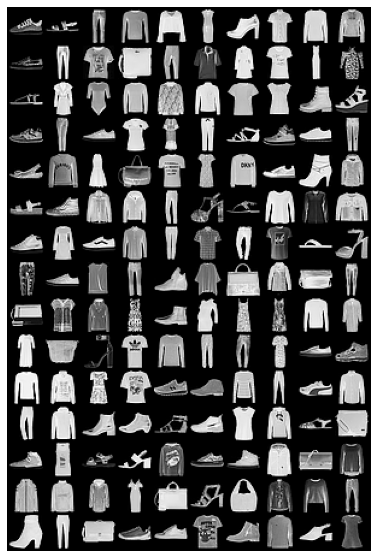

In [ ]:
for images, _ in train_loader :
  print('images.shape:', images.shape)
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute(1,2,0))
  break

In PyTorch, we have to create a function to plot the accuracy (doesn't automatically exist).
We obtain it by taking the rate/percentage of labels that were predicted correctly.

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1) 
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Here, we create our model. In the **`__init__()`** constructor method we create two layers, one is the output layer and we chose to only get one hidden layer. We could have used 2 or more layers if we had a more complex dataset. However I didn't find it necessary here. But if we had multiple layers, we would have to pass the output of each layer to the next until we pass it through the activation function RELU and get the "final" result in the output layer. This process is done in the **`forward()`** method. 

Next, for both the **`training_step()`** and **`validation_step()`** we have to use our batch size to determine how many images and how many labels we will use (which is one of the reasons why this model is specific to this dataset). The loss is then calculated through cross_entropy for both training and validation and the accuracy function is used for the validation and uses the output from the training.

In **`val_epoch()`**, we are simply extracting the accuracy and results of this specific epoch for each batch and combining them together into a tensor.




In [ ]:
class FMNIST_model(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.linear_hidden = nn.Linear(in_size, hidden_size)
    self.linear_out = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1) # Flatten the image to a vector
    out = self.linear_hidden(xb) # Get output of the hidden layer
    out = F.relu(out) # Applying activation function
    out = self.linear_out(out) # Get output of the output layer
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc} 

  def val_epoch(self, outputs):
    batch_loss = [x['val_loss'] for x in outputs] # Extracting all the outputs from the outputs (predictions)
    epoch_loss = torch.stack(batch_loss).mean() # Combining losses into a tensor
    batch_acc = [x['val_acc'] for x in outputs] # Extracting all the accuracies from the outputs (predictions)
    epoch_acc = torch.stack(batch_acc).mean() # Combining accuracies into a tensor
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epochprint(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Using a GPU for more efficiency

In [ ]:
torch.cuda.is_available()

True

This became true after changing on colab:


Modifier > paramètres du notebook > GPU

In [ ]:
torch.backends.cudnn.enabled

True

In [ ]:
def get_default_device(): # To know if we have to change the notebook's parameters
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('CPU')
device = get_default_device()
device

device(type='cuda')

Now that we verified that we are in the right place, let's start using the GPU by moving the tensors to the chosen device :

In [ ]:
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return[to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)
  
for images, labels in train_loader :
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([150, 1, 28, 28])
cuda:0


Creating a class for placing the data to the device "device".

In [ ]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device) # yield is like return but instead it will return a generator

  def __len__(self): # nb of batches
    return len(self.dl)

Moving the training and validation batches to the device.

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
def evaluation(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.val_epoch(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluation(model, val_loader)
        model.epochprint(epoch, result)
        history.append(result)
    return history

Hidden size is the number of nodes for the hidden layer.

Number of classes was found earlier by finding the number of labels.

In [ ]:
input_size = 784 # =(28*28)
hidden_size = 30
num_classes = 10

Model = FMNIST_model(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(Model, device)

FMNIST_model(
  (linear_hidden): Linear(in_features=784, out_features=30, bias=True)
  (linear_out): Linear(in_features=30, out_features=10, bias=True)
)

In [ ]:
# First trial of the model (randomly initialized)
history = [evaluation(Model, val_loader)]
history

[{'val_acc': 0.11539214849472046, 'val_loss': 2.2968828678131104}]

The accuracy is around 10% which is what one might expect from this randomly initialized model containing 10 possible labels (P = 1/10)

Now, let's create now epochs and train the model :

In [ ]:
history += fit(5, 0.5, Model, train_loader, val_loader)

Epoch [0], val_loss: 0.7832, val_acc: 0.7098
Epoch [1], val_loss: 0.6190, val_acc: 0.7734
Epoch [2], val_loss: 0.4426, val_acc: 0.8429
Epoch [3], val_loss: 0.5021, val_acc: 0.8228
Epoch [4], val_loss: 0.4965, val_acc: 0.8175


In [ ]:
history += fit(5, 0.1, Model, train_loader, val_loader)

Epoch [0], val_loss: 0.3874, val_acc: 0.8648
Epoch [1], val_loss: 0.3896, val_acc: 0.8597
Epoch [2], val_loss: 0.3962, val_acc: 0.8595
Epoch [3], val_loss: 0.3836, val_acc: 0.8640
Epoch [4], val_loss: 0.3809, val_acc: 0.8644


We should avoid overtraining at this point, the model seems to slow down at 86% accuracy, which is good. Let's plot the data to confirm our observations.

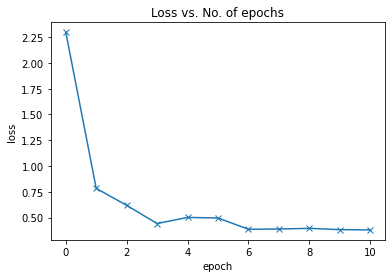

In [ ]:
losses = [x['val_loss'] for x in history] # loop to put all val_loss in one 
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

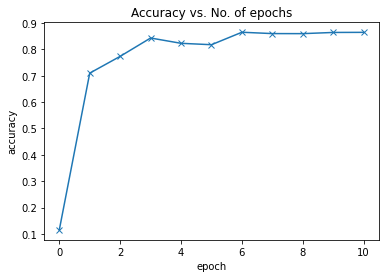

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')